In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [47]:
# Load Data
uav = pd.read_csv('uav_flight_data.csv')

# TODO: Read the datetime from the parameters file
start = dt.datetime(year=2015,month=1,day=1)
uav['time'] = uav['time'] + start.timestamp()
uav["time"] = pd.to_datetime(uav["time"], unit='s')

uav = uav[['time', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'position_x']]

# Do I still need this for this clean dataset?
uav.fillna(uav.bfill())

# Extract the training and test datasets
train = uav[:int(len(uav)*0.8)]
test = uav[int(len(uav)*0.8):]

In [75]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = np.array(scaler.fit_transform(train[['linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'position_x']]))
print('Scaled Data Shape: ', scaled_data.shape)

window_sample_size = 256
print('Window sample size: ', window_sample_size)

# NOTE: We are only going to use ACCEL_Z predict POS_Z to keep the problem univariate
x_train = []
y_train = []
# Build the sliding window of samples (find the technical word for this ... maybe in sktime?)
for x in range(window_sample_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_sample_size:x, 2])
    y_train.append(scaled_data[x, 3])

x_train, y_train = np.array(x_train), np.array(y_train)
print('X Train Data Shape: ', x_train.shape)
# Add another dimension for some reason?
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('X Train Data Shape: ', x_train.shape)
print('Y Train Data Shape: ', y_train.shape)


Scaled Data Shape:  (1447, 4)
Window sample size:  256
X Train Data Shape:  (1191, 256)
X Train Data Shape:  (1191, 256, 1)
Y Train Data Shape:  (1191,)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 128)          66560     
                                                                 
 dropout_3 (Dropout)         (None, 256, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 256, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 256, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

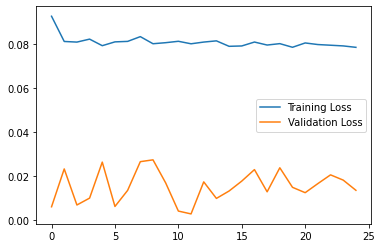

In [76]:
# Build The Model
model = Sequential()

model.add(LSTM(units =128, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

## Need to figure out how the data size and the batch_size work ... need to optimize for a GPU system.  Higher batch size works much better on the GPU (less overhead)
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)


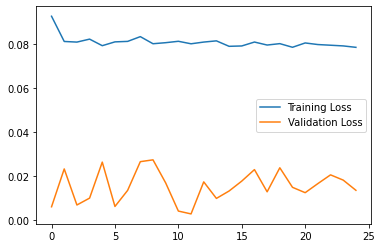

Help on History in module keras.callbacks object:

class History(Callback)
 |  Callback that records events into a `History` object.
 |  
 |  This callback is automatically applied to
 |  every Keras model. The `History` object
 |  gets returned by the `fit` method of models.
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
 |  >>> model.compile(tf.keras.optimizers.SGD(), loss='mse')
 |  >>> history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
 |  ...                     epochs=10)
 |  >>> print(history.params)
 |  {'verbose': 1, 'epochs': 10, 'steps': 1}
 |  >>> # check the keys of history object
 |  >>> print(history.history.keys())
 |  dict_keys(['loss'])
 |  
 |  Method resolution order:
 |      History
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  on_epoch_end(self, epoch, logs=None)
 |      Calle

In [84]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

help(history)
print(history.params)
print(history.history.keys())

In [ ]:
### Test the Model Accuracy on Existing Data ###
################################################

# take Test data Again
test.head()
actual_temp = test['Avg_Temp'].values
total_temp = pd.concat((train['Avg_Temp'], test['Avg_Temp']),axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred = model.predict(x_test)
print('Predictions:\n', pred[:][:10])
pred = scaler.inverse_transform(pred)
print('Inverse Transformed Predictions\n', pred[:][:10])

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test['Avg_Temp'], pred)

In [ ]:
### Visualization ###
#####################
pred_ = pd.DataFrame(test['Date'])
pred_['Avg_Temp'] = pred
pred_["Date"] = pd.to_datetime(pred_["Date"])

pred_
original = florida.loc[florida['Date'] >= '1990-01-01']

import seaborn as sns
sns.lineplot(original['Date'], original['Avg_Temp'])
sns.lineplot(pred_['Date'], pred_['Avg_Temp'])
plt.show()